Cette page doit être lancée sur Kaggle, depuis la compétition pour avoir accès aux données. Sinon vous devez récupérer les données séparément.

In [14]:
import tensorflow as tf
import numpy as np # linear algebra
import pandas as pd 
import matplotlib.pyplot as plt# data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.display import FileLink
SEED = 25
np.random.seed(SEED)
tf.random.set_seed(SEED)
OUTPUT_DIR = '/kaggle/working/outputs'

In [15]:
!mkdir /kaggle/working/outputs

mkdir: cannot create directory ‘/kaggle/working/outputs’: File exists


## Lire les images

cf https://keras.io/api/data_loading/image/ et 
https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [16]:
directory_path = "/kaggle/input/navires-2023-la-mano/ships16x24/ships_16x24_10cat/data"
ds_train, ds_val = tf.keras.utils.image_dataset_from_directory(directory_path, labels='inferred',subset='both',shuffle=True,validation_split=0.2,seed=SEED,image_size=(16,24))


Found 35515 files belonging to 10 classes.
Using 28412 files for training.
Using 7103 files for validation.


In [17]:
ds_train

<BatchDataset element_spec=(TensorSpec(shape=(None, 16, 24, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Résultat à soumettre

In [18]:
class CheckValidationLossCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, patience=0):
        self.patience = patience
        self.counter = 0

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        train_loss = logs.get('loss')
        if val_loss < train_loss:
            self.counter = 0
            print(f"\nValidation loss ({val_loss:.4f}) is less than training loss ({train_loss:.4f})")
        else:
            self.counter +=1
            
        if(self.counter == self.patience):
            self.model.stop_training = True

In [19]:
def test_phase(model):
    file_name = f'submission.csv'
    X_test = np.load('/kaggle/input/navires-2023-la-mano/test.npy', allow_pickle=True)
    X_test = X_test.astype('float32')
    res = model.predict(X_test).argmax(axis=1)
    df = pd.DataFrame({"Category":res})
    df.to_csv(os.path.join(OUTPUT_DIR,file_name), index_label="Id")

def save_history(model,history):
    history_df = pd.DataFrame(history.history)
    hist_file_name = f"history_{model.name}.csv"
    history_df.to_csv(os.path.join(OUTPUT_DIR,hist_file_name))

def save_model(model):
    model_file_name = f"{model.name}.h5"
    model.save(os.path.join(OUTPUT_DIR,model_file_name))

In [35]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D,MaxPooling2D, MaxPooling2D, Dropout,Flatten, Dense, BatchNormalization, Rescaling, LeakyReLU
from tensorflow.keras.models import load_model
"""
def build_model() -> Model:
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, 3, activation='relu', input_shape=(16, 24, 3)),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(32, 3, activation='relu',padding='same'),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Dropout(0.5),
         tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same'),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.6),
        tf.keras.layers.Dense(10,activation='softmax')
    ])
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
    
    return model"""
def build_model(input_shape=(16, 24, 3), num_classes=10) -> Model:
    model = Sequential([
        Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same'),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(128, (3, 3), padding='same'),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(256),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        Dropout(0.65),
        Dense(num_classes, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=optimizer,
                  metrics=['accuracy'])

    return model
model = build_model()
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 16, 24, 32)        896       
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 16, 24, 32)        0         
                                                                 
 batch_normalization_29 (Bat  (None, 16, 24, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 16, 24, 64)        18496     
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 16, 24, 64)        0         
                                                                 
 batch_normalization_30 (Bat  (None, 16, 24, 64)       256       
 chNormalization)                                     

Epoch 1/75


2023-05-14 10:42:12.378550: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/dropout_27/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


888/888 [==============================] - 31s 31ms/step - loss: 2.0346 - accuracy: 0.3846 - val_loss: 1.3905 - val_accuracy: 0.5095
Epoch 2/75
888/888 [==============================] - 27s 31ms/step - loss: 1.4286 - accuracy: 0.5117 - val_loss: 1.2504 - val_accuracy: 0.5707
Epoch 3/75
888/888 [==============================] - 28s 31ms/step - loss: 1.3130 - accuracy: 0.5511 - val_loss: 1.3363 - val_accuracy: 0.5306
Epoch 4/75
888/888 [==============================] - 27s 30ms/step - loss: 1.2511 - accuracy: 0.5706 - val_loss: 1.1765 - val_accuracy: 0.6007
Epoch 5/75
888/888 [==============================] - 28s 31ms/step - loss: 1.1982 - accuracy: 0.5916 - val_loss: 1.2505 - val_accuracy: 0.5681
Epoch 6/75
888/888 [==============================] - 27s 31ms/step - loss: 1.1594 - accuracy: 0.6025 - val_loss: 1.1176 - val_accuracy: 0.6154
Epoch 7/75
888/888 [==============================] - 27s 30ms/step - loss: 1.1206 - accuracy: 0.6137 - val_loss: 1.0509 - val_accuracy: 0.6368
Epo

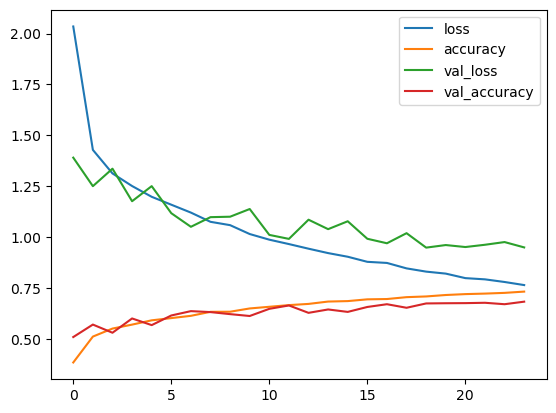

In [36]:
def train_and_test(epochs=50,model=None):
    callbacks = []
    #callbacks.append(CheckValidationLossCallback(patience=3))
    callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))
    if model is None:
        model = build_model() 
    history = model.fit(ds_train,epochs=epochs,validation_data=ds_val,callbacks=callbacks,batch_size = 200)
    test_phase(model)
    save_model(model)
    save_history(model,history)
    return history

#model = load_model('/kaggle/input/model-bast/sequential_18.h5')
history = train_and_test(epochs=75,model=model)
test_phase(model)
save_model(model)

pd.DataFrame(history.history).plot()
plt.show()

In [24]:
FileLink('outputs/submission.csv')

/kaggle/working/outputs/submission.csv

In [ ]:
!rm -rf ships32/

In [ ]:
print("Nombre de couches : ", len(model.layers))